In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/phi2_lora_finetune/checkpoint-250'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install -q transformers torch datasets accelerate peft

In [3]:
!pip install -U bitsandbytes

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [5]:
# Load and clean dataset
file_path = "/kaggle/input/gloss-textpairs/words and code - Sheet2.csv"
data = pd.read_csv(file_path)
data.rename(columns={'ZZZ': 'Text'}, inplace=True)
data_tmp = data[['Text', 'Gloss']].dropna()

In [6]:
# Convert columns to string format
data_tmp["Text"] = data_tmp["Text"].astype(str)
data_tmp["Gloss"] = data_tmp["Gloss"].astype(str)

In [7]:
# Load Phi-2 model with 4-bit LoRA
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Define prompt template for instruction fine-tuning
prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Convert the following English sentence into ASL gloss.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    texts = []
    for text, gloss in zip(examples["Text"], examples["Gloss"]):
        formatted_text = prompt_template.format(text, gloss) + EOS_TOKEN
        texts.append(formatted_text)
    return {"text": texts}

# Convert to Hugging Face Dataset and format text
dataset = Dataset.from_pandas(data_tmp)
dataset = dataset.map(formatting_prompts_func, batched=True)

# Tokenization function with labels
def tokenize_function(examples):
    model_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    model_inputs["labels"] = model_inputs["input_ids"].copy()  # Ensure labels exist
    return model_inputs

# Tokenize dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Convert dataset to Pandas for splitting
df = tokenized_dataset.to_pandas()

df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate columns

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/5043 [00:00<?, ? examples/s]

Map:   0%|          | 0/5043 [00:00<?, ? examples/s]

In [8]:
# Train-test split (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert back to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

# Create dataset dictionary
dataset_dict = DatasetDict({"train": train_dataset, "validation": val_dataset})
print(f"Train size: {len(dataset_dict['train'])}, Validation size: {len(dataset_dict['validation'])}")

Train size: 4034, Validation size: 1009


In [9]:
# LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    use_dora=True
)

# Prepare model for training with 4-bit LoRA
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 9,748,480 || all params: 2,789,432,320 || trainable%: 0.3495


In [10]:
# Training arguments with reduced time
training_args = TrainingArguments(
    output_dir="./phi2_lora_finetune",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,  # Reduce training time
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",  # Changed to 'steps' to match evaluation_strategy
    save_steps=50,        # Save every 50 steps
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,  # Slightly lower for stability
    weight_decay=0.01,
    num_train_epochs=3,  # Reduce epochs to speed up training
    save_total_limit=1,  # Save only the best checkpoint
    metric_for_best_model="loss",
    greater_is_better=False,
    load_best_model_at_end=True,
    bf16=True,  # More stable for 4-bit LoRA training
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Trainer setup with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Reduce early stopping patience
)

<ipython-input-11-32aa14be8e8f>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
#Train the model
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,4.954900,0.414837
100,0.676600,0.285786
150,0.573200,0.269420
200,0.554800,0.259109
250,0.527800,0.252821
300,0.515900,0.249440
350,0.490700,0.244935
400,0.486000,0.242788
450,0.483000,0.240346
500,0.498400,0.236938


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

TrainOutput(global_step=756, training_loss=0.8025730179731178, metrics={'train_runtime': 14661.7003, 'train_samples_per_second': 0.825, 'train_steps_per_second': 0.052, 'total_flos': 2.463827891847168e+16, 'train_loss': 0.8025730179731178, 'epoch': 2.99009900990099})

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Define the saved model path
save_path = "/kaggle/working/phi2_lora_finetune/checkpoint-750"


# Load the model in half-precision (float16) and send it to GPU if available
model = AutoModelForCausalLM.from_pretrained(
    save_path,
    torch_dtype=torch.float16,  # Reduce memory usage
    device_map="auto"  # Automatically place on GPU if available
)
tokenizer = AutoTokenizer.from_pretrained(save_path)

print("✅ Model(dora) loaded successfully with optimized memory usage!")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model(dora) loaded successfully with optimized memory usage!


**Let's evaluate it**


In [15]:
import torch

# Ensure tokenizer is set up correctly
tokenizer.padding_side = "left"  # Fix padding warning
tokenizer.pad_token = tokenizer.eos_token  # Ensure pad token is set

def generate_gloss_batch(text_list, max_new_tokens=50, batch_size=4):
    gloss_outputs = []

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)  # Move model to GPU if available

    for i in range(0, len(text_list), batch_size):  # Process in mini-batches
        batch_texts = text_list[i:i+batch_size]

        # Format prompts
        prompts = [f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

        ### Instruction:
        Convert the following English sentence into ASL gloss.

        ### Input:
        {text}

        ### Response:
""" for text in batch_texts]

        # Tokenization with explicit padding and attention mask
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=256)
        input_ids = inputs.input_ids.to(device)
        attention_mask = inputs.attention_mask.to(device)

        # Generate output with max_new_tokens instead of max_length
        with torch.inference_mode():
            output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens)

        # Decode outputs
        generated_texts = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        # Extract gloss from each response
        glosses = [gen.split("### Response:")[-1].strip() for gen in generated_texts]
        gloss_outputs.extend(glosses)

        # Free memory
        del inputs, input_ids, attention_mask, output_ids
        torch.cuda.empty_cache()  # Clear GPU memory

    return gloss_outputs

In [16]:

# Example test
text_samples = [  "The magician performed amazing tricks",
    "The dentist checked my teeth carefully",
    "He left school",
    "The dog barked loudly",
    "She took pictures today"

]


gloss_outputs = generate_gloss_batch(text_samples)
for i, gloss in enumerate(gloss_outputs):
    print(f"Original: {text_samples[i]}")
    print(f"Generated ASL Gloss: {gloss}\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original: The magician performed amazing tricks
Generated ASL Gloss: MAGICIAN TRICK PERFORM AMAZING

Original: The dentist checked my teeth carefully
Generated ASL Gloss: TEETH DENTIST CHECK CAREFUL

Original: He left school
Generated ASL Gloss: HIM SCHOOL LEAVE

Original: The dog barked loudly
Generated ASL Gloss: DOG BARK LOUDLY

Original: She took pictures today
Generated ASL Gloss: TODAY SHE PHOTO TAKE



In [17]:
!pip install rouge-score nltk matplotlib seaborn evaluate sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9d0c22eb33ff6081adaaaff55820b9d2e0233a4f24097ee5dfc247a431dfe7bc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [18]:
import evaluate
# Load evaluation metrics
eval_bleu = evaluate.load("bleu")
eval_rouge = evaluate.load("rouge")
eval_ter = evaluate.load("ter")
eval_chrf = evaluate.load("chrf")
eval_perplexity = evaluate.load("perplexity", module_type="metric")

In [19]:
# Function to generate gloss predictions
def generate_glosses(texts, model, tokenizer, batch_size=8):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=50)
        glosses = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        predictions.extend(glosses)
    return predictions

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


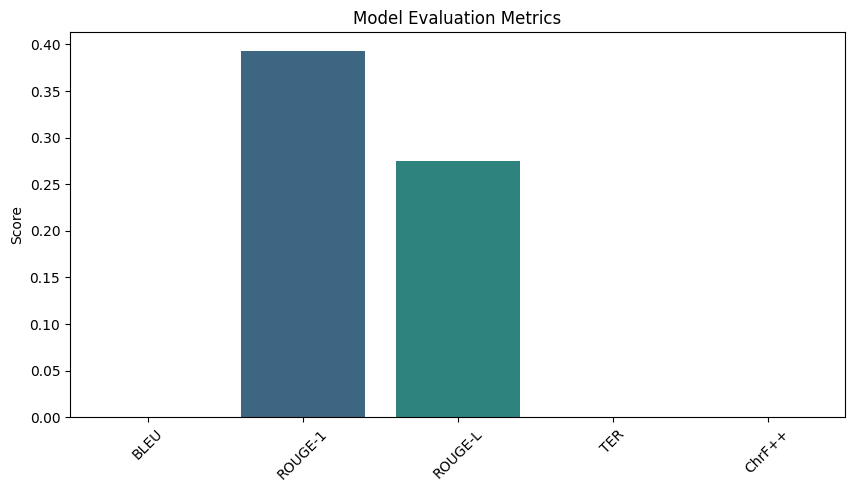

In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate gloss predictions in batches
def evaluate_model_in_batches(val_texts, model, tokenizer, batch_size=10):
    all_predictions = []

    for i in range(0, len(val_texts), batch_size):
        batch_texts = val_texts[i : i + batch_size]

        # Tokenize and generate predictions
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=50)

        # Decode predictions and store
        batch_predictions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        all_predictions.extend(batch_predictions)

        # Free up memory
        torch.cuda.empty_cache()

    return all_predictions

# Load validation dataset (ensure lists)
val_texts = list(val_dataset["Text"][:30])
val_glosses = [str(gloss) for gloss in val_dataset["Gloss"][:30]]

# Process dataset in batches
generated_glosses = evaluate_model_in_batches(val_texts, model, tokenizer, batch_size=10)

# Compute evaluation metrics
bleu_score = eval_bleu.compute(predictions=generated_glosses, references=val_glosses)
rouge_score = eval_rouge.compute(predictions=generated_glosses, references=val_glosses)
# meteor_score = eval_meteor.compute(predictions=generated_glosses, references=val_glosses)
ter_score = eval_ter.compute(predictions=generated_glosses, references=val_glosses)
chrf_score = eval_chrf.compute(predictions=generated_glosses, references=val_glosses)

# Organize metrics (handle missing keys)
metrics = {
    "BLEU": bleu_score.get("bleu", 0),
    "ROUGE-1": rouge_score.get("rouge1", 0),
    "ROUGE-L": rouge_score.get("rougeL", 0),
    "TER": ter_score.get("ter", 0),
    "ChrF++": chrf_score.get("chrf", 0),
}

# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


In [21]:
# Print evaluation results
print("\n🔹 Model Evaluation Scores:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")



🔹 Model Evaluation Scores:
BLEU: 0.0000
ROUGE-1: 0.3934
ROUGE-L: 0.2753
TER: 0.0000
ChrF++: 0.0000


In [22]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=2560, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2560, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict(
              (default): lora.dora.DoraLinearLayer()
            )
          )
          (k_proj): Linear(in_features=2560, out_features=2560, bias=